<a href="https://colab.research.google.com/github/curiosity806/machine-learning-and-practice-report/blob/new_try/Dacon_satellite_dist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# 훈련 데이터
!cp '/content/drive/My Drive/2020 Kaggle Study/data/train.npy' train.npy

In [84]:
import numpy as np
train = np.load('train.npy')

In [4]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Conv2DTranspose, MaxPooling2D, BatchNormalization, Activation, concatenate, Input, GlobalAveragePooling2D
from tensorflow.keras import Model
import warnings
import gc
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import stats
from mpl_toolkits.axes_grid1 import make_axes_locatable
warnings.filterwarnings("ignore")

# 재생산성을 위해 시드 고정
np.random.seed(7)
random.seed(7)
tf.random.set_seed(7)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## high leverage point
채널 별 히스토그램을 그려 분포 확인

In [ ]:
train.shape

(76345, 40, 40, 15)

In [ ]:
76345 * 40 *40

122152000

In [ ]:
gc.collect()

33160

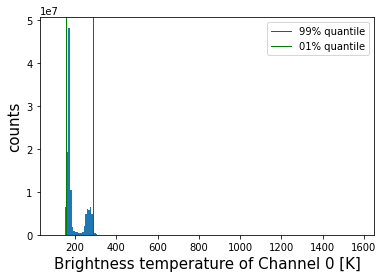

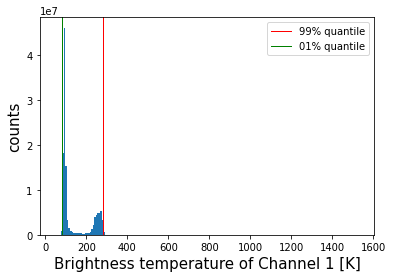

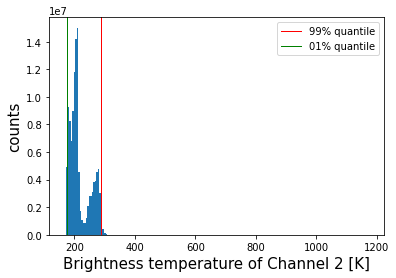

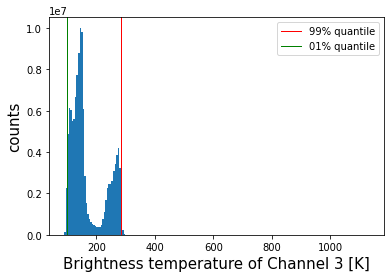

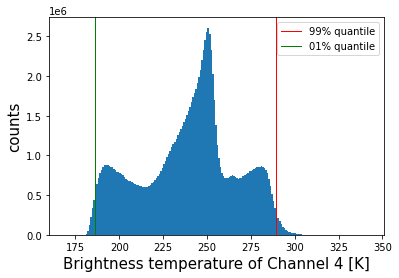

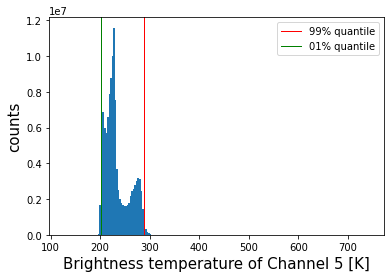

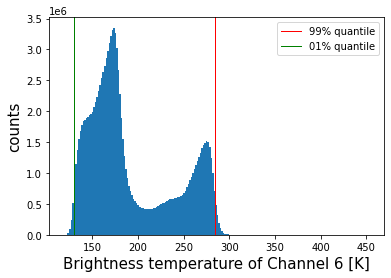

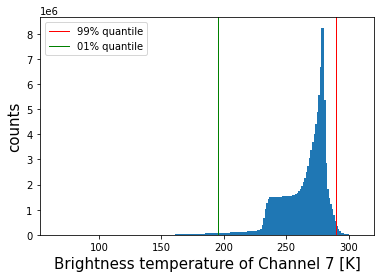

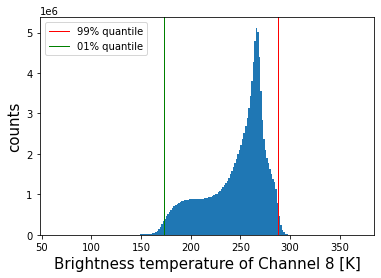

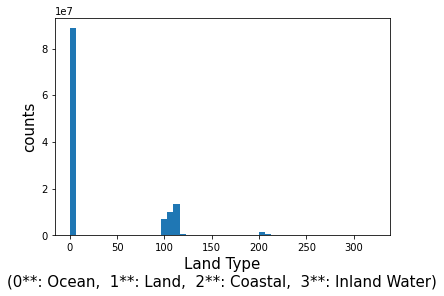

38401

In [ ]:
quantile_99pers = []# 채널별로 조사해서 list로 저장
quantile_01pers = []

for i in range(9):
    quantile_99per = np.quantile(train[:,:,:,i].reshape(-1), .99)
    quantile_99pers.append(quantile_99per)#list에 추가

    quantile_01per = np.quantile(train[:,:,:,i].reshape(-1), .01)
    quantile_01pers.append(quantile_01per)#list에 추가

    plt.hist(train[:,:,:,i].reshape(-1), bins = 200)
    plt.axvline(x = quantile_99per, linewidth=1, color='r', label='99% quantile')
    plt.axvline(x = quantile_01per, linewidth=1, color='green', label='01% quantile')
    plt.legend()
    plt.ylabel('counts', fontsize = 15)
    plt.xlabel('Brightness temperature of Channel {} [K]'.format(i), fontsize = 15)
    plt.show()

plt.hist(train[:,:,:,9].reshape(-1), bins = 50)
plt.ylabel('counts', fontsize = 15)
plt.xlabel('Land Type\n(0**: Ocean,  1**: Land,  2**: Coastal,  3**: Inland Water)', fontsize = 15)
plt.show()

gc.collect()

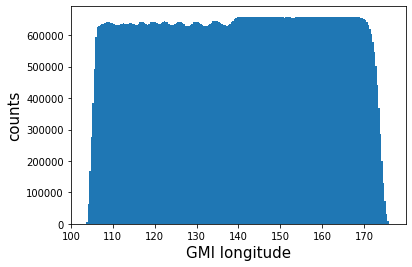

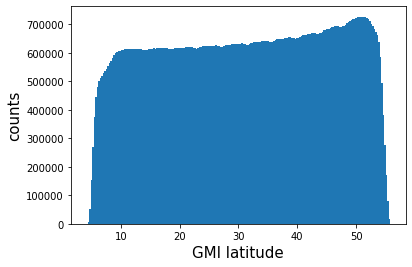

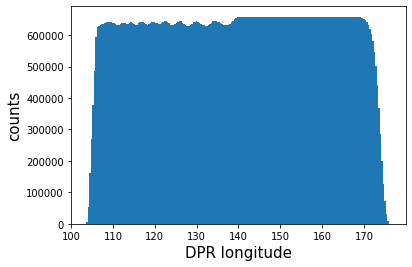

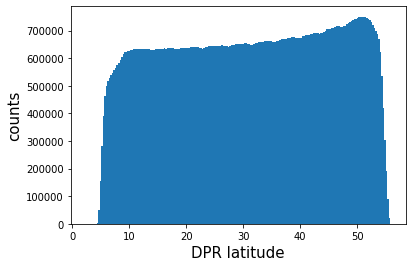

15963

In [ ]:
plt.hist(train[:,:,:,10].reshape(-1), bins = 200)
plt.ylabel('counts', fontsize = 15)
plt.xlabel('GMI longitude', fontsize = 15)
plt.show()

plt.hist(train[:,:,:,11].reshape(-1), bins = 200)
plt.ylabel('counts', fontsize = 15)
plt.xlabel('GMI latitude', fontsize = 15)
plt.show()

plt.hist(train[:,:,:,12].reshape(-1), bins = 200)
plt.ylabel('counts', fontsize = 15)
plt.xlabel('DPR longitude', fontsize = 15)
plt.show()

plt.hist(train[:,:,:,13].reshape(-1), bins = 200)
plt.ylabel('counts', fontsize = 15)
plt.xlabel('DPR latitude', fontsize = 15)
plt.show()

gc.collect()

In [ ]:
np.sum(train[:,:,:,-1].reshape(-1) < 0)

543756

In [5]:
print('결측값의 비율:', 543756/train.reshape(-1).shape[0]*100, '%')

결측값의 비율: 0.02967646866199489 %


In [81]:
train[:,:,:,-1].reshape(-1)[train[:,:,:,-1].reshape(-1) < 0] = 0 # 결측치의 값은 모두 0으로 변경

# 강수량 합 100 미만인 데이터 자르기 + 결측값(-9999.xx)을 0으로 치환

train_labels = []
for i in range(len(train)):
    sample_lable = train[i,:,:,-1].reshape(-1)
    cutoff_labels = np.where(sample_lable < 0, 0, sample_lable)
    if (cutoff_labels > 0).sum() >= 100:
        train_labels.append(i)

train = train[train_labels]
gc.collect()

424

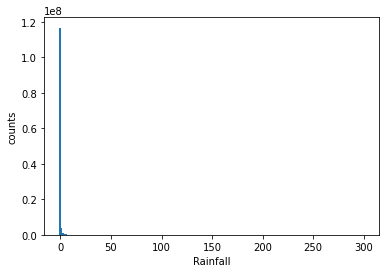

In [ ]:
# 결측값 제외한 Target(강수량) 분포 시각화
plt.hist(train[:,:,:,-1].reshape(-1), bins = 200)
plt.ylim()
plt.ylabel('counts', fontsize = 15)
plt.xlabel('Rainfall', fontsize = 15)
plt.show()

In [ ]:
np.sum(train[:,:,:,-1].reshape(-1) == 0) / train[:,:,:,-1].reshape(-1).shape[0] * 100

92.83886796777784

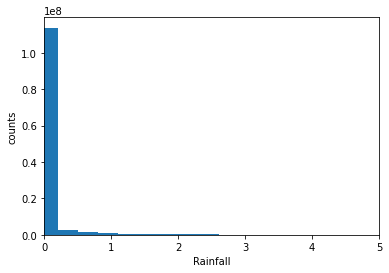

In [ ]:
# 결측값 제외한 Target(강수량) 분포 시각화

plt.hist(train[:,:,:,-1].reshape(-1), bins = 100000)
plt.ylabel('counts', fontsize = 15)
plt.xlabel('Rainfall', fontsize = 15)
plt.xlim(0, 2)
plt.show()

In [ ]:
def outlier(data, channel):
    x = data[:,:,:,channel].reshape(-1)
    q99 = np.quantile(x, .99)
    q995 = np.quantile(x, .995)
    q999 = np.quantile(x, .999)
    q9999 = np.quantile(x, .9999)
    print('1%:', q99, '\n0.5%:', q995, '\n0.1%', q999, '\n0.01%', q9999)

In [ ]:
for i in range(14):
    print(i)
    outlier(train, i)

0
1%: 288.49365234375 
0.5%: 292.1386109924315 
0.1% 300.23187261962903 
0.01% 343.91686407775796
1
1%: 282.1341247558594 
0.5%: 284.7510070800781 
0.1% 294.6739807128906 
0.01% 481.45509247738937
2
1%: 289.1573181152344 
0.5%: 292.2474365234375 
0.1% 299.05261233520514 
0.01% 305.54607544250484
3
1%: 284.2022402954103 
0.5%: 286.3955993652344 
0.1% 290.4615783691406 
0.01% 295.22819214782703
4
1%: 289.43011474609375 
0.5%: 291.91241455078125 
0.1% 297.57928472900403 
0.01% 303.32353516235344
5
1%: 288.213134765625 
0.5%: 291.1036376953125 
0.1% 297.6339111328125 
0.01% 304.21281738891594
6
1%: 284.3915100097656 
0.5%: 286.6398620605469 
0.1% 291.234375 
0.01% 297.23833008422844
7
1%: 289.4615173339844 
0.5%: 291.29470840454087 
0.1% 295.3923034973145 
0.01% 300.64605105895953
8
1%: 287.79840087890625 
0.5%: 289.4349060058594 
0.1% 292.79003909301764 
0.01% 297.1440673858642
9
1%: 206.0 
0.5%: 212.0 
0.1% 300.0 
0.01% 300.0
10
1%: 173.2702943420411 
0.5%: 173.87850952148438 
0.1% 174.8

In [ ]:
print('강수량이 299.xx인 데이터 갯수: ', np.sum(train[:,:,:,-1].reshape(-1) > 299))

강수량이 299.xx인 데이터 갯수:  1259


## high leverage point 제거
channel 0~8에서 하나라도 300 이상인 값들 제거

In [ ]:
for i in range(9):
    globals()["idx" + str(i)] = np.unique(np.where(train[:,:,:,i].reshape(-1) >= 300)[0] // 1600)

In [ ]:
idx = np.concatenate([idx0, idx1, idx2, idx3, idx4, idx5, idx6, idx7, idx8])
idx = np.unique(idx)
idx_del = np.delete(np.arange(train.shape[0]), idx)
train = train[idx_del,:,:,:]

In [8]:
train.shape

(21155, 40, 40, 15)

In [85]:
train[:,:,:,-1].reshape(-1)[train[:,:,:,-1].reshape(-1) < 0] = 0 # 결측치의 값은 모두 0으로 변경
# 강수량 합 100 미만인 데이터 자르기 + 결측값(-9999.xx)을 0으로 치환

train_labels = []
for i in range(len(train)):
    sample_lable = train[i,:,:,-1].reshape(-1)
    cutoff_labels = np.where(sample_lable < 0, 0, sample_lable)
    if (cutoff_labels > 0).sum() >= 100:
        train_labels.append(i)

train = train[train_labels]
train[:,:,:,-1].reshape(-1)[train[:,:,:,-1].reshape(-1) < 0] = 0
gc.collect()

train = train.reshape([-1,15])

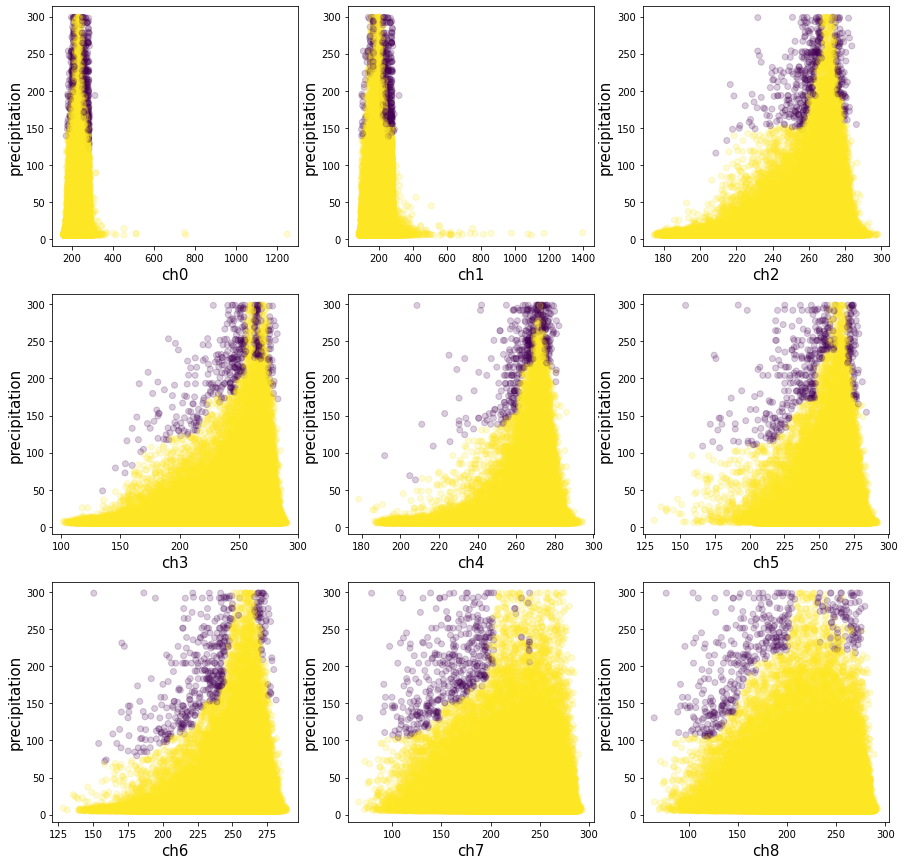

In [94]:
from sklearn.ensemble import IsolationForest

train_pre = train[train[:,-1]>5]
train_pre = train_pre[train_pre[:,-1]<299]

clfs = []
plt.figure(figsize = (15,15))

for ch in range(9):

    clf = IsolationForest(contamination  = 0.0007)
    clf.fit(train_pre[:,[ch,-1]])
    clfs.append(clf)
    plt.subplot(3,3,ch+1)
    outlier = clf.predict(train_pre[:,[ch,-1]])
    plt.scatter(x = train_pre[:,ch],y = train_pre[:,-1], c = outlier, alpha = 0.2)
    plt.xlabel(f'ch{ch}',fontsize=15)
    plt.ylabel('precipitation', fontsize=15)

plt.show()

In [95]:
print(f"전처리 전 이미지 수 : {train.shape[0]//1600}")
print(f"전처리 전 픽셀 수 : {train.shape[0]}")

drops = []
for ch in range(9):
    outlier = clf[ch].predict(train[:,[ch,-1]])
    drop = np.where(outlier == -1)[0]//1600
    drops.append(drop)
drops = np.array(drops).reshape(-1)
drops = np.unique(drops)
print(f"삭제할 이미지 수 : {len(drops)}")

undrops = np.delete(np.arange(train.shape[0]//1600),drops)
train = train.reshape([train.shape[0]//1600,1600,15])[undrops]
print(f"전처리 후 이미지 수 : {train.shape[0]}")

train = train.reshape(-1,15)
print(f"전처리 후 픽셀 수 : {train.shape[0]}")
print(train.shape)

전처리 전 이미지 수 : 21155
전처리 전 픽셀 수 : 33848000
삭제할 이미지 수 : 0
전처리 후 이미지 수 : 21155
전처리 후 픽셀 수 : 33848000
(33848000, 15)


In [98]:
clf[1].predict(train[:,[1,-1]])

array([0.01177241, 0.01177241, 0.01177241, ..., 0.01177241, 0.01177241,
       0.01177241])

In [71]:
np.arange(train.shape[0]//1600)

array([    0,     1,     2, ..., 21152, 21153, 21154])

In [63]:
drops = []
drops.append(drop[0])
drops.append(drop[0])

In [66]:
len(np.array(drops).reshape(-1))

1249038

In [61]:
len(drops)

2

In [34]:
outlier

array([0.52201004, 0.52201004, 0.52201004, ..., 0.9369273 , 0.9369273 ,
       0.9369273 ])

In [35]:
outlier = clf[1].predict(train_pre[:,[1,-1]])

In [36]:
outlier

array([0.54359967, 0.54359967, 0.54359967, ..., 0.54359967, 0.54359967,
       0.54359967])